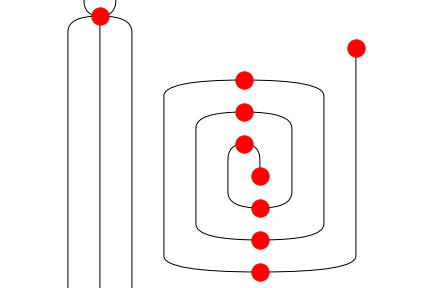

In [1]:
from discopy import *
from PIL import Image

diagram = Box('f', Ty('x', 'x'), Ty('x', 'x', 'x'))\
    @ moncat.spiral(3)

params = dict(
    draw_types=False,
    draw_as_nodes=True,
    draw_box_labels=False,
    margins=(0.05, 0),
    path='../docs/imgs/test-pixels2diagram.png')

diagram.draw(**params)
img = Image.open(params['path'])
img

In [2]:
import numpy as np

arr = np.array(img)
print("height, width, [red, blue, green, opacity]: {}".format(arr.shape))

height, width, [red, blue, green, opacity]: (288, 432, 4)


Found 9 boxes:


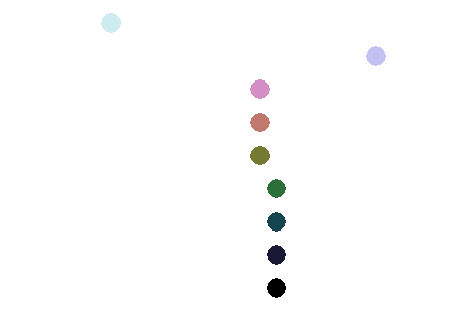

In [3]:
from skimage import measure
from matplotlib import pyplot as plt


threshold = 127
red = np.logical_and(arr[:, :, 0] > threshold,
                     arr[:, :, 1] < threshold,
                     arr[:, :, 2] < threshold)
boxes, n_boxes = measure.label(red, return_num=True)
print("Found {} boxes:".format(n_boxes))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(-boxes, cmap='cubehelix')
plt.show()

Found 12 wires:


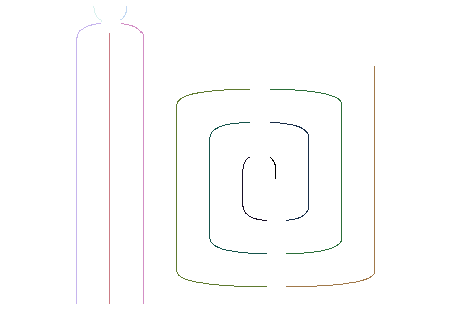

In [4]:
wires, n_wires = measure.label(arr[:, :, 0] < threshold, return_num=True)
print("Found {} wires:".format(n_wires))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(-wires, cmap='cubehelix')
plt.show()